# Predicting Home Prices in El Salvador

After graduating from Amherst College in 2017, I worked as an investment analyst at a real estate and retail firm with operations in San Salvador, El Salvador and Managua, Nicaragua. One of the responsabilities of my role was to evaluate potential investment properties to determine a fair purchase price. I wondered whether it would be possible to build an analytics model that would help me estimate a property's value by analyzing a set of property factors such as Area and Location. I also wondered whether analytics could help suggest what are the most important predictors of a property's price in El Salvador.

Note that I started this project before my Master of Analytics at Georgia Tech. Most, if not all, of the work and knowledge therein is a result of self study. 

## The Data 

The data used for this analysis was scraped using Scrapy from Encuentra24.com, an online listings website used in El Salvador. The variables I will be using for data cleaning and modeling are: 

1) **Title (string):** Listing's title

2) **Price (int):** Listing's price in USD

3) **Area (int):** Listing's area in meters squared

4) **City (String):** Listing's city 

5) **Description (String):** Listing's description

7) **Link (string):** Listing's url

8) **Rooms (int):** Number of bedrooms

9) **Reduced (boolean):** Whether the price has been reduced 

I decided to do some feature engineering and created the following predictors: 

10) **Commercial (boolean):** Whether the house is designated by the seller as appropriate for commercial purposes

11) **Exclusive Neighborhood (boolean):** Denotes whether the house is located in one of the exclusive (expensive) neighborhoods of El Salvador

Given that gang crime is a strong determinant in house prices, I also added crime data from El Salvador's police register:

12) **#Murders (int):** Number of murders committed by gangs in the homes' city or municipality in 2014

## Project Approach:

1. Import and clean data
2. Feature engineering
3. Exploratory Data Analysis
4. Scale data
5. Training and validation using different regression models
6. Choose best model and test on a testing set

## Data Preparation

Below I clean and prepared the listings data. Given that anyone can put a listing, the data I scraped had a lot of innacuracies, such as listings that were not for homes, repeated listings, listings with wrong prices (e.g. billion dollar listings). I also had to make the data apt for analysis (e.g. by converting to int). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import chart_studio.plotly as py
import plotly.tools as tls


#We upload a file of homes listed for sale on April 10, 2019. 
#To gather this data, I used Scrapy to scrape the Encuentra24 listings-for-sale website
df = pd.read_csv('//Users/reynaldo/Documents/homes_july.csv')
df.head()

,Title,Price,Area,City,Rooms,Description,Date Posted,Price Reduced,Link
0,SE VENDE PRECIOSA Y COMODA CASA EN COLONIA PR...,"$250,000.00",322 m,Zaragoza,5,\nPreciosa casa estilo colonial inmersa en una...,Hace 6 días,NaN,https://www.encuentra24.com/el-salvador-es/bie...
1,"Condado de Santa Elena, a estrenar, $365K y 5...","$365,000.00",251 m,San Salvador,3,\nse vende linda casa a estrenar en Condado de...,Hace 10 días,NaN,https://www.encuentra24.com/el-salvador-es/bie...
2,"Casa en Santa Ana, El Trebol, comoda y funcio...","$59,000.00",93 m,Santa Ana,2,\nSanta Ana: en un área en constante desarroll...,Hace 21 días,NaN,https://www.encuentra24.com/el-salvador-es/bie...
3,Venta Casa Escalon parte baja sobre calle pri...,"$199,000.00",262 m,San Salvador,4,\nVenta Casa Escalon entre la 75 av.nte y la A...,Hace 23 días,NaN,https://www.encuentra24.com/el-salvador-es/bie...
4,Venta Casa Lomas de San Francisco pasaje privado,"$145,000.00",143 m,San Salvador,3,"\nVenta casa Lomas Sfco pjeprivado\nSala, come...",Hace 25 días,(rebajado 26%),https://www.encuentra24.com/el-salvador-es/bie...


I drop dupliates and check null entries. The only variables with missing values are Price (6 missing) and Price Reduced (1537 missing). Missing values in the Price Reduced column refer to listings whose prices were not reduced, so we can easily fill in these values. 

In [2]:
#There are repeated data points so we remove them if they have the same title or Description
df.drop_duplicates(subset='Title', keep='first', inplace = True)
df.drop_duplicates(subset='Description', keep='first', inplace = True)

print (df.isnull().sum())

Title               0
Price               6
Area                0
City                0
Rooms               0
Description         0
Date Posted         0
Price Reduced    1537
Link                0
dtype: int64


After checking missing Price values, I saw that a few were non-home listings so I removed them. The rest of the entries with missing values will be later imputed using the median for that city's price.

In [76]:
df.drop(730, inplace = True)
df.drop(1843, inplace = True)

#I dropped an observation with a strange price (nonUSD) 
df.drop(df.loc[df.Price =='SV₡17,000'].index, inplace = True)

In [77]:
#we change the 'Dates Posted' column to show only the approximate days the listing has been posted. 
def change_date(x):
    if 'meses' in x:
        number = x[5:-6]
        date = int(number)*30
        return date
    
    elif 'mes' in x:
        return 30
    
    elif 'días' in x:
        date = x[5:-5]
        return int(date)
    
    else:
        return 1
    
def clean_data(df):
    
    #We clean the "Area" column
    #This eliminates the 'm' character that stands for "meters squared"
    #Some "Area" values have decimals so we also round them
    df['Area'] = df['Area'].map(lambda x: str(x)[:-1])
    df["Area"].replace(' ', np.nan, inplace = True)
    df["Area"]= df["Area"].map(lambda x: float(x))

    #To conduct our linear regression analysis, we are going to delete the observations with 
    #unreasonable Area values. We delete all listings with area greater than 5000 m2.
    #5000 is a reasonable threshold value because the vast majority of homes are less than 5000 
    #squared meters in size, and those that are greater are usually farms or simply a digiting error
    #We also delete observations with less than 50 squared meters bc it is likely a digiting error
    df.drop(df.loc[df.Area>5000].index, inplace = True)
    df.drop(df.loc[df.Area<50].index, inplace = True)

    #replace missing values with median
    df["Area"].replace(np.nan, df['Area'].median(), inplace = True)
    df["Area"]= df["Area"].map(lambda x: round(x))

    #We turn each column into lowercase for easier handling
    df['Description'] = df['Description'].str.lower()
    df['Title'] = df['Title'].str.lower()
    
    #We clean the 'Price' column
    #We eliminate two decimals and the "$" and "," in the Price column
    df['Price'] = df['Price'].map(lambda x: str(x)[1:-3])
    df['Price'] = df['Price'].map(lambda x: x.replace(",", ""))
    df["Price"].replace('', np.nan, inplace = True)
    df["Price"]= df["Price"].map(lambda x: float(x))
        
    #We eliminate all observations that have a Price value less than $5,200 or more than $3,000,000
    #This is done to eliminate listings for things other than houses for sale (such as rentals or cars)
    #We eliminate extremely high values because they are very likely a digiting error 
    #(extremely few houses (if any) are worth more than US$3M in El Salvador)
    df.drop(df.loc[df.Price<5200].index, inplace = True)
    df.drop(df.loc[df.Price>3000000].index, inplace = True)

    df['Date Posted'] = df['Date Posted'].apply(change_date)

    #We rename all El Salvador values in City column as "Other" as this doesn't provide any city information 
    #We also rename all City values that appear less than 10 times as "Other" since they have too little observations 
    #for regression analysis
    df['City'].replace('El Salvador', 'Other', inplace = True)
    s=df['City'].value_counts()
    df['City'] = df['City'].map(lambda x: 'Other' if x in s[s<10].index else x)
    
    #We rename the Reduced column to booleans to denote whether price has been reduced or not
    df['Price Reduced'] = df['Price Reduced'].map(lambda x: True if isinstance(x, str) else False)


clean_data(df)

#replace missing values with median and cast strings as int
median_SM = df[(df.City == 'San Miguel')].Price.median()
median_Colon = df[(df.City == 'Colón')].Price.median()

df.loc[list(df[(df.City == 'San Miguel') & (df.Price.isnull())].index), 'Price']= median_SM
df.loc[list(df[(df.City == 'Colón') & (df.Price.isnull())].index), 'Price']=  median_Colon
df["Price"]= df["Price"].map(lambda x: int(round(x)))

## Feature Engineering

I decide to create a new variable denoting whether a home is located in an exclusive part of the city, as I think that this greatly correlated with a property's listing price. A property is designated as located in an exclusive neighborhood if one of the keywords below (exclusive) appear in either the title or description of the property's listing. 

In [78]:
#feature engineering by creating a binary column that tells whether the home belongs to one of the exclusive neighborhoods
exclusive = ['merliot', 'maquilishuat', 'escalón', 'cuscatlán', 'benito', 'carmen', 'escalon', 
    'madreselva', 'francisco','piletas', 'tecla', 'elena', 'altamira', 'cuscatlan', 'montaña', 'rosa', 
    'utila', 'teresa', 'sueños', 'tenerife', 'florida', 'portal', 'encanto', 'tuscania', 'cerromar', 'xanadu',
    'costa del sol', 'palmira', 'suenos', 'montana', 'coatepeque', 'madre selva']

def contains_string(x):
    for word in exclusive:
        if word in x['Title'] or word in x['Description']:
            return True
    else:
        return False
    
def create_exclusive_column(df):
    df['Exclusive Neighborhood'] = df.apply(contains_string, axis = 1)
    
create_exclusive_column(df)

I also create a new variable denoting whether a house is designated for commercial purposes (e.g. to put a business or store). A house is designated as apt for commercial purposes if one of the keywords below (keys) appear in either the title or the description of the listing. 

In [79]:
#We create a feature to determine whether the home is designated as "commercial"
keys = ['comercial', 'comercio', 'negocio', 'negocios', 'comercios', 'oficina', 'inversion', 'locales']

def is_commercial(x):
    for word in keys:
        if word in x['Title'] or word in x['Description']:
            return True
    else:
        return False
    
def create_commerce_col(df):
    
    df['Commercial'] = df.apply(is_commercial, axis = 1)
    
create_commerce_col(df)

There are only 66 properties designated as appropriate for commercial properties, which is a small but important minority. Commercial properties tend to be the most expensive. Now I add a murder rate column for each city.

In [80]:
#We add a column of data about murders committed by gangs in each city or municipality in 2014

#This data is gathered from El Salvador's Office of Justice and Public safety: https://www.transparencia.gob.sv/institutions/mjsp/documents/estadisticas
df2 = pd.read_csv('//Users/reynaldo/Documents/Encuentra24/DATOS CASAS/MURDERS COMMITED BY GANGS IN 2014.csv', names = ['Municipality', 'Murders'])

#We turn each column into lowercase in order to do left joins
df['City'] = df['City'].str.lower()
df2['Municipality'] = df2['Municipality'].str.lower()

#replace a mispelling in order to do the join correctly
df2.replace('colon', 'colón', inplace= True)
df2.replace('zacatecoluca', 'la paz', inplace = True)

#The data has repeated cities/municipalities because it originally divided the data by gang 
#So we add the numbers that appear in each city and make sure each city appears only once
df2= df2.groupby('Municipality')[['Murders']].sum()

#do a join between the two dataframes
df = pd.merge(df, df2, left_on = "City", right_on = "Municipality", how = "left")
df.groupby("City")[["Murders"]].sum()

#Should I used la libertad or san salvador murder rate???
#We filled some by the city in which they are located and we filled the 'other' with the median of #murders
df.loc[df['City'] == 'santa tecla', 'Murders'] = int(df2.loc['san salvador'].Murders)
df.loc[df['City'] == 'antiguo cuscatlán', 'Murders'] = int(df2.loc['san salvador'].Murders)
df.loc[df['City'] == 'other', 'Murders'] = df2['Murders'].median()

In [81]:
#delete a few listings that were clearly not for homes (such as hotels)
df.drop(568, inplace = True)
df.drop(1166, inplace = True)
df.drop(1498, inplace = True)
df.drop(1417, inplace = True)
df.drop(1442, inplace = True)
df.drop(1271, inplace = True)
df.drop(1066, inplace = True)
df.drop(881, inplace = True)
df.drop(786, inplace = True)
df.drop(642, inplace = True)
df.drop(376, inplace = True)

Correct a few values below for listings that had wrongly imputed values. I also drop all rows except the first where Price, Area, and City match exactly. I also drop all rows except the first whose Title is the same. These are clear repetitions that we weed out. 

In [82]:
df.at[1276, 'Area']= 600
df.at[62, 'Price']= 40000
df.at[1182, 'Price']= 48000
df.at[22, 'Murders']= 28
df.at[498, 'Murders']= 4
df.at[816, 'Murders']= 28
df.at[864, 'Murders'] = 28
df.at[1026, 'Exclusive Neighborhood'] = True
df.at[1277, 'Murders']= 28
df.at[1409, 'Murders']= 28
df.at[678, 'Murders']= 28
df.at[726, 'Murders']= 28
df.at[10, 'Murders']= 28

#I delete all rows that share the exact same Price, Area, and City given that they are very likely to be duplicates. 
#It is not an infallible method of deleting duplicate rows but it is good enough, as it deletes around 200 rows
#most of which were actually duplicate listings. 
df.drop_duplicates(subset=['Price', 'Area', 'City'], keep='first', inplace = True)

#After correcting data, there may be duplicate Titles so I drop them again
df = df.drop_duplicates(subset='Title', keep='first')

df.reset_index(drop=True, inplace= True)

A drawback of the drop_duplicates() method is that it only deletes rows that are exactly the same in the columns I specify. Many properties are listed multiple times with slightly different values, such as when price is slightly lowered or if the seller makes a spelling mistake. I use the following functions to delete rows of repeated listings that were not detected by the drop_duplicates() method. This code helps us delete such repeated listings by getting a similarity ratio for the 'Title', 'Price', and 'Area' columns. If the similarity ratio for all three is sufficiently small (within 10% for both Price and Area), then we delete one of the rows. This code was made with help from StackOverflow. It is useful to avoid manually going over the whole data set in search of potential duplicates, although running time is O(N^2). This function succesfully detects 60 duplicates and deletes them. 

In [83]:
from fuzzywuzzy import fuzz

def fuzzy_compare(a,b):
    val=fuzz.partial_ratio(a,b)
    return val

tl = df["Title"].tolist()
itered=1
i=0

repeated_row  = {}

def delete_repeated(i):
    itered=i+1    
    while itered < len(tl):
        val=fuzzy_compare(tl[i],tl[itered])
        if val > 80:
            if abs((df.loc[i,'Price'])/(df.loc[itered,'Price']))>0.90 and abs((df.loc[i,'Price'])/(df.loc[itered,'Price']))<1.11:
                if abs((df.loc[i,'Area'])/(df.loc[itered,'Area']))>0.90 and abs((df.loc[i,'Area'])/(df.loc[itered,'Area']))<1.11:
                    df.drop(itered,inplace=True)
                    df.reset_index()
                    pass
                else:
                    pass
            else:
                pass            
        else:
            pass
        itered=itered+1 
    
while i < len(tl)-1:
    try:
        delete_repeated(i)
        i=i+1
    except:
        i=i+1
        pass
else:
    pass

Drop a few erroneous or repeated rows once more:

In [84]:
#Drow a few more listings that are incorrect
df.drop(153, inplace = True)
df.drop(587, inplace = True)
df.drop(561, inplace = True)
df.drop(895, inplace = True)
df.drop(874, inplace = True)
df.drop(494, inplace = True)
df.drop(924, inplace = True)
df.drop(689, inplace = True)
df.drop(382, inplace = True)
df.drop(1122, inplace = True)
df.drop(149, inplace = True)
df.drop(582, inplace = True)
df.drop(578, inplace = True)
df.drop(1047, inplace = True)
df.drop(746, inplace = True)
df.drop(933, inplace = True)
df.drop(583, inplace = True)
df.drop(1210, inplace = True)
df.drop(530, inplace = True)
df.drop(962, inplace = True)
df.drop(610, inplace = True)
df.drop(883, inplace = True)
df.drop(519, inplace = True)
df.drop(181, inplace = True)
df.drop(102, inplace = True)
df.drop(70, inplace = True)
df.drop(659, inplace = True)
df.drop(611, inplace = True)
df.drop(615, inplace = True)
df.drop(968, inplace = True)
df.drop(208, inplace = True)
df.drop(91, inplace = True)
df.drop(182, inplace = True)

# Final Data Set:

I choose the delete all rows that are not used for data analysis and modeling, such as Title, Description, and Link. I also chose to delete the City column since it is a categorical variable with 10+ category values. Including this variable in regression models, while including a few other variables that are highly correlated to City (such as Murders, Exclusive Neihborhood, and Commericial) didn't seem wise as linear regression requires uncorrelated predictors. Additionally, having too many similar variables reduces our model's statistical strength. 

In [86]:
df.drop(['Title', 'City', 'Description', 'Link'], axis=1, inplace = True)
df.head()

,Price,Area,Rooms,Date Posted,Price Reduced,Exclusive Neighborhood,Commercial,Murders
0,250000,322,5,6,False,False,False,4.0
1,365000,251,3,10,False,True,False,28.0
2,59000,93,2,21,False,False,False,11.0
3,199000,262,4,23,False,True,False,28.0
4,145000,143,3,25,True,True,False,28.0


## Exploratory Data Analysis

Interestingly, almost half of all listings on the website are located in neighborhoods designated as exclusive (as define above). This means that a large part of listings correspond to properties in the capital city of San Salvador. Also, around 10% of listings correspond to properties apt for commercial purposes. 

In [87]:
print('Proportion of listings located in exclusive neighborhoods:', round(len(df[df['Exclusive Neighborhood'] == True])/len(df),2))
print('Proportion of listings categorized as apt for commercial purposes:', round(len(df[df.Commercial == True])/len(df),2))

Proportion of listings located in exclusive neighborhoods: 0.44
Proportion of listings categorized as apt for commercial purposes: 0.11


Below are a few distributions of our variables. As expected, area and price are heavily right skewed. Interestingly, number of murders is also right skewed, showing that most cities have few murders. This is a bit surprising given El Salvador's high murder rate, but it makes sense that most murders are concentrated in the most densely populated areas (like the capital city). The remaining numerical variables: Room Numbers and Date Posted are also right skewed. The skewed data suggests that I should try doing some log transformation to see if it improves model accuracy.

Text(0.5, 1.0, 'Histogram of Date Posted')

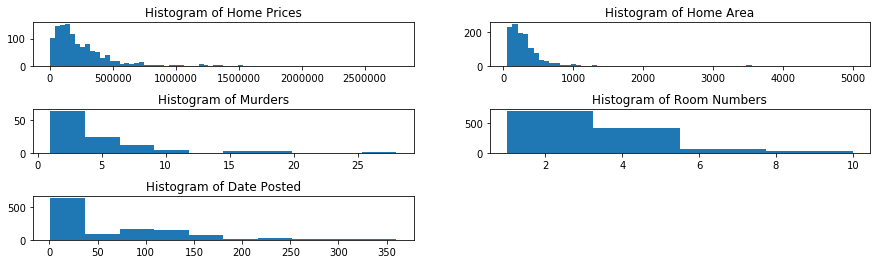

In [88]:
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=1)
ax1 = fig.add_subplot(321)
ax1.hist(df.Price, bins=70)
ax1.set_title('Histogram of Home Prices')

ax2 = fig.add_subplot(322)
ax2.hist(df["Area"], bins = 65)
ax2.set_title('Histogram of Home Area')

ax3 = fig.add_subplot(323)
ax3.hist(df2["Murders"], bins = 10)
ax3.set_title('Histogram of Murders')

ax4 = fig.add_subplot(324)
ax4.hist(df['Rooms'], bins=4)
ax4.set_title('Histogram of Room Numbers')

ax5 = fig.add_subplot(325)
ax5.hist(df['Date Posted'], bins=10)
ax5.set_title('Histogram of Date Posted')

I check if my numerical predictors and Price are linearly correlated. Evidently, most data points tend to be concentrated at the lower values of Area and Date Posted. It seems like  

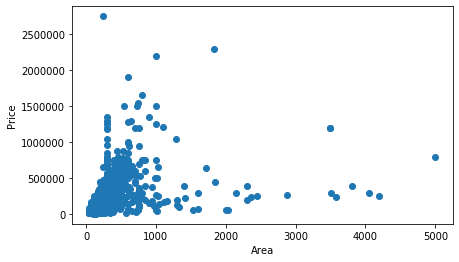

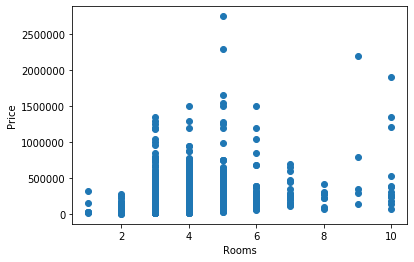

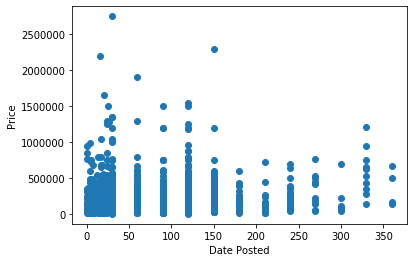

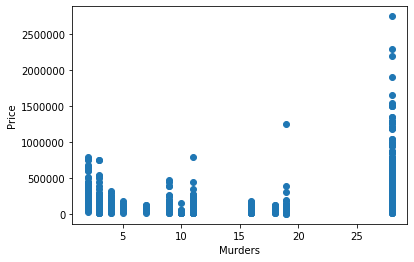

In [89]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(221)
plt.scatter(df.Area, df.Price)
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

ax1 = fig.add_subplot(222)
plt.scatter(df.Rooms, df.Price)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

ax1 = fig.add_subplot(223)
plt.scatter(df['Date Posted'], df.Price)
plt.xlabel('Date Posted')
plt.ylabel('Price')
plt.show()

ax1 = fig.add_subplot(224)
plt.scatter(df.Murders, df.Price)
plt.xlabel('Murders')
plt.ylabel('Price')
plt.show()

We get median Price statistics. Clearly, median price of listings deemed as located in exclusive neighborhoods is a bit over US300,000, almost three times as much as those listings located in non exclusive neighborhoods. Also, properties deemed as apt for commercial purposes are listed a bit above US250,000, also higher than non commercial properties with a median price around US160,000. 

As expected, median area is also larger for exclusive neighborhoods and commercial properties, although the degree of difference is a bit less than that of Price. 
I didn't plot graphs for murder rate because it has less variation than the other variables.

<BarContainer object of 5 artists>

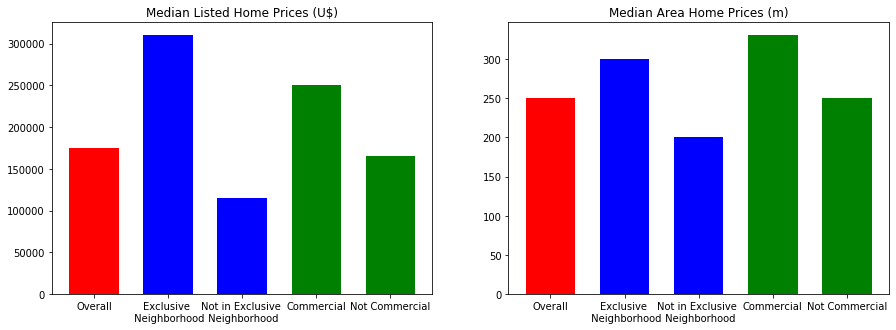

In [90]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(121)
y = [df['Price'].median(), df[df['Exclusive Neighborhood']==True].Price.median(), df[df['Exclusive Neighborhood']==False].Price.median(), df[df['Commercial']==True].Price.median(), df[df['Commercial'] == False].Price.median()]
N = len(y)
x = ['Overall', 'Exclusive \n Neighborhood', 'Not in Exclusive \n Neighborhood', 'Commercial', 'Not Commercial']
width = 1/1.5
ax1.set_xticks(range(len(x)), x)
ax1.set_title('Median Listed Home Prices (U$)')
ax1.bar(x, y, width, color=['r', 'b', 'b', 'g', 'g'])

ax2 = fig.add_subplot(122)
y = [df['Area'].median(), df[df['Exclusive Neighborhood']==True].Area.median(), df[df['Exclusive Neighborhood']==False].Area.median(), df[df['Commercial']==True].Area.median(), df[df['Commercial'] == False].Area.median()]
N = len(y)
x = ['Overall', 'Exclusive \n Neighborhood', 'Not in Exclusive \n Neighborhood', 'Commercial', 'Not Commercial']
width = 1/1.5
ax2.set_xticks(range(len(x)), x)
ax2.set_title('Median Area Home Prices (m)')
ax2.bar(x, y, width, color=['r', 'b', 'b', 'g', 'g'])

Finally let's see the bar graph of the price per square meter. The price per square meter is about twice as high in exclusive neighborhoods compared to those not in exclusive neighborhoods. Price per square meter roughly the same in commercial as in non commercial homes, which is a bit counterintuitive as commercial properties are in high demand and sell for higher prices. This may indicate that many properties that are listed as apt for commercial purposes may not really be 'grade A' properties (such as in shopping malls), but are rather lower grade properties that are repurposed for commercial purposes and attract lower income tenant businesses. 

<BarContainer object of 5 artists>

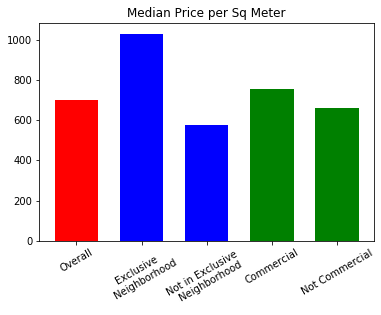

In [91]:
y = [df['Price'].median()/df['Area'].median(), df[df['Exclusive Neighborhood']==True].Price.median()/df[df['Exclusive Neighborhood']==True].Area.median(), df[df['Exclusive Neighborhood']==False].Price.median()/df[df['Exclusive Neighborhood']==False].Area.median(), df[df['Commercial']==True].Price.median()/ df[df['Commercial']==True].Area.median(), df[df['Commercial'] == False].Price.median()/ df[df['Commercial']==False].Area.median()]
N = len(y)
x = ['Overall', 'Exclusive \n Neighborhood', 'Not in Exclusive \n Neighborhood', 'Commercial', 'Not Commercial']
width = 1/1.5
plt.xticks(range(len(x)), x, rotation = 30)
plt.title('Median Price per Sq Meter')
plt.bar(x, y, width, color=['r', 'b', 'b', 'g', 'g'])

We create boxplots to see potential outliers within each of the cities (each city is represented by a murder rate). I explored potential outliers to determine whether to delete them or not, and found that all data points outside of usual ranges are either large homes or expensive luxury homes. The data preparation step was succesful :)

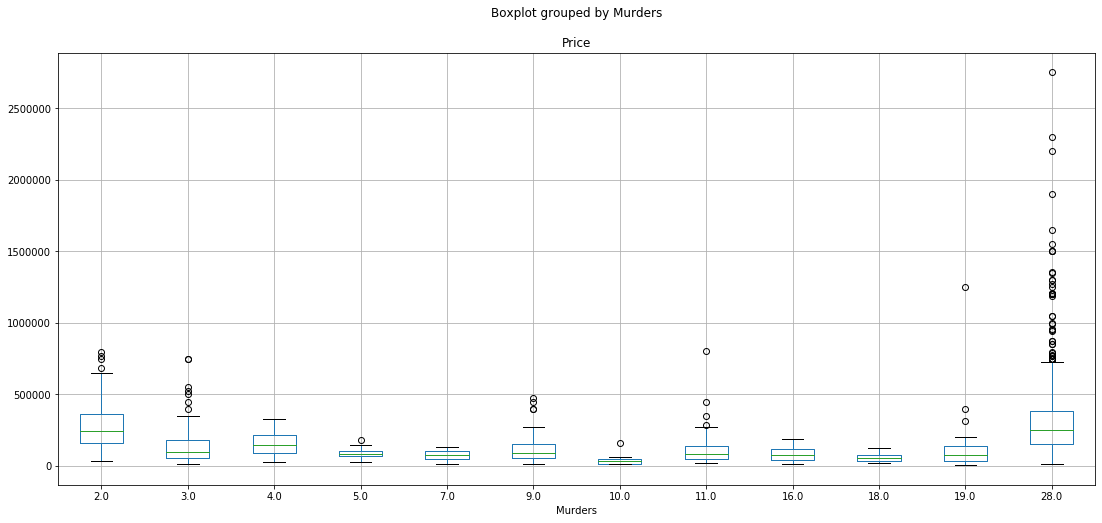

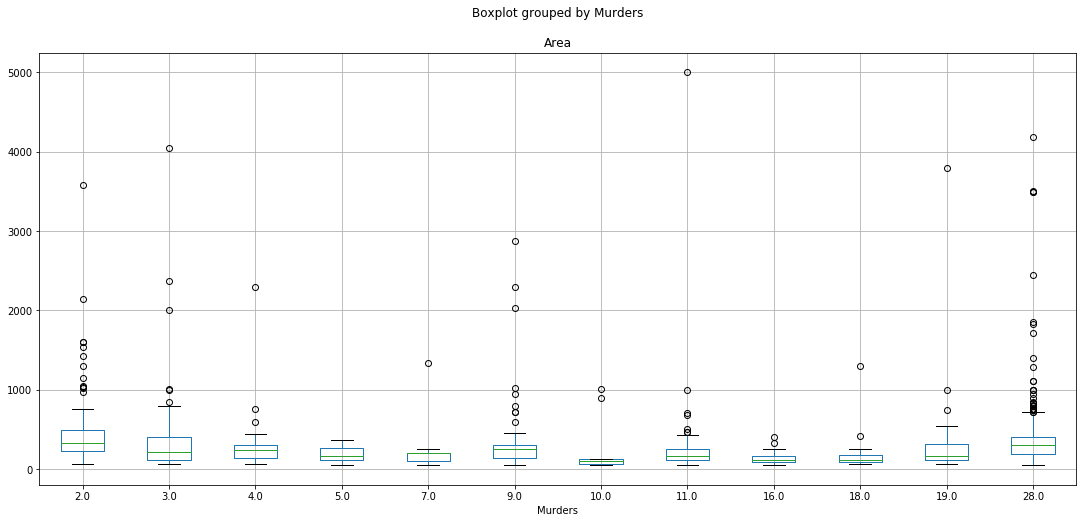

In [92]:
df.boxplot(column='Price', by='Murders', figsize=(18,8))

df.boxplot(column='Area', by='Murders', figsize=(18,8))

As seen below, Exclusive Neighborhoods and Murders are fairly correlated, so I will also try out lasso and PCA regression. 

In [93]:
df.corr()

,Price,Area,Rooms,Date Posted,Price Reduced,Exclusive Neighborhood,Commercial,Murders
Price,1.000000,0.352186,0.293303,0.087836,-0.056528,0.416159,0.116161,0.292352
Area,0.352186,1.000000,0.298380,0.096898,0.001016,0.099973,0.032438,-0.018486
Rooms,0.293303,0.298380,1.000000,0.057685,-0.008193,0.019963,0.296053,0.096813
Date Posted,0.087836,0.096898,0.057685,1.000000,0.150501,0.017018,0.012393,-0.046251
Price Reduced,-0.056528,0.001016,-0.008193,0.150501,1.000000,0.017143,-0.018701,-0.042142
Exclusive Neighborhood,0.416159,0.099973,0.019963,0.017018,0.017143,1.000000,0.007097,0.428078
Commercial,0.116161,0.032438,0.296053,0.012393,-0.018701,0.007097,1.000000,0.117206
Murders,0.292352,-0.018486,0.096813,-0.046251,-0.042142,0.428078,0.117206,1.000000


## Scale Data

I scale the independent variables (with mean zero and unit standard deviation) in order to get more interpretable results from regression models. I also code the binary variables into 0 and 1, where 1= True and 0 = False, and create a new dataframe df1 with a log transformation of response variable, and another dataframe dfd2 with a log-log transformation of response and predictors, to see whether log transforms improve model performance in linear regression:

In [94]:
df_original = df.copy()

def scale_df(df):
    df.loc[:, 'Area'] = (df['Area']-np.mean(df['Area']))/np.std(df['Area'])
    df.loc[:, 'Rooms'] = (df['Rooms']-np.mean(df['Rooms']))/np.std(df['Rooms'])
    df.loc[:, 'Murders'] = (df['Murders']-np.mean(df['Murders']))/np.std(df['Murders'])
    df.loc[:,'Date Posted'] = (df['Date Posted']-np.mean(df['Date Posted']))/np.std(df['Date Posted'])
    df.loc[:,"Price Reduced"]= df["Price Reduced"].map(lambda x: 1 if x==True else 0)
    df.loc[:,"Exclusive Neighborhood"]= df["Exclusive Neighborhood"].map(lambda x: 1 if x==True else 0)
    df.loc[:,"Commercial"]= df["Commercial"].map(lambda x: 1 if x==True else 0)

#Create a dataframe with a log transformation of response variable and scaled data
df1 = df.copy()
df1['Price']= np.log(df1['Price'])
scale_df(df1)

df2=df.copy()
df2['Price'] = np.log(df['Price'])
df2['Area'] = np.log(df['Area'])
df2['Rooms'] = np.log(df['Rooms'])
df2['Murders'] = np.log(df['Murders'])
df2['Date Posted'] = np.log(df['Date Posted'])
scale_df(df2)

#We also scale the original dataframe without log transformation
scale_df(df)

## Modeling Details

I will use the Mean Absolute Percentage Error to evaluate my models, as it is a more interpretable error measure. I will also separate my data into 85% training and 15% testing set in order to choose (and eventually test) the best model:

In [161]:
from sklearn.metrics import make_scorer
def MAPE(y_true, y_pred, **kwargs):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

my_scorer = make_scorer(MAPE, greater_is_better=False)

I create the following scorer to get MAE in terms of original (non log) scale. I use for cross validating some of my models.

In [166]:
def loss_func(y_true, y_pred):
     return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))) * 100

score = make_scorer(loss_func, greater_is_better=False)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Price'], df['Price'], test_size=0.15, random_state=3)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.loc[:, df1.columns != 'Price'], df1['Price'], test_size=0.15, random_state=3)

X_train2, X_test2, y_train2, y_test2 = train_test_split(df2.loc[:, df2.columns != 'Price'], df2['Price'], test_size=0.15, random_state=3)

## Baseline Model

We simply calculate the median price value for our homes in the training set and use it as prediction in the training set:

In [97]:
#define MAE to use in our baseline model
def mae(predictions, targets):
    return np.abs(predictions - targets).mean()

In [151]:
from sklearn.model_selection import KFold

kf = KFold(10)

sum_error = 0
for train_index, test_index in kf.split(X_train):
    x_train, x_test = X_train.loc[train_index], X_train.loc[test_index]
    Y_train, Y_test = y_train.loc[train_index], y_train.loc[test_index]
    median = int(np.median(Y_train))
    y_pred = [median] * len(x_test)
    MAE = MAPE(y_pred, Y_test)
    sum_error += MAE

print('Baseline Model MAPE:', round(sum_error/10,2))

Baseline Model MAPE: 87.68


## Multivariate Linear Regression

The first model I try building is multivariate linear regression. 

In [165]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring=my_scorer, cv=10)
print ('Multivariate Regression MAE:', round((-scores).mean(),2))

Multivariate Regression MAE: 72.89


Evidently, we see lack of residual independence below, since errors are not randomly distributed but rather decrease as Y increase. We also see non constant variance. I will try to transform the response to make residuals have constant variance.

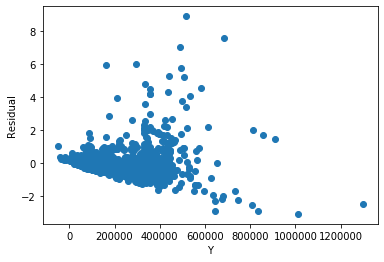

In [153]:
model = lm.fit(X_train, y_train)
pred = model.predict(X_train)
resid = y_train-pred
sd = np.std(resid)
stand_resid = resid/sd
plt.scatter(pred, stand_resid)
plt.xlabel('Y')
plt.ylabel('Residual')
plt.show()

As seen below, the standardized residuals are very right skew. This is expected since the response variable is also very right skewed. It doesn't seem to be problematic, though. I'm more concerned with the lack of residual independence. 

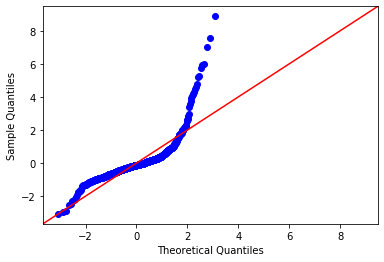

In [154]:
import statsmodels.api as sm
import pylab

test = np.random.normal(0,1, 1000)

sm.qqplot(stand_resid, line='45')
pylab.show()

(array([ 10., 137., 723., 101.,  26.,   6.,   8.,   3.,   2.,   1.]),
 array([-3.07714091, -1.8810715 , -0.68500208,  0.51106733,  1.70713675,
         2.90320616,  4.09927558,  5.29534499,  6.49141441,  7.68748382,
         8.88355324]),
 <a list of 10 Patch objects>)

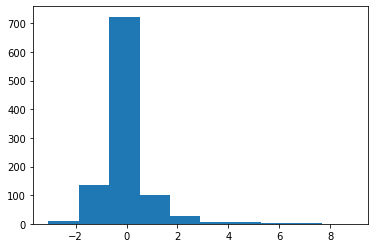

In [155]:
plt.hist(stand_resid)

I'll see if applying a log transformation to the response variable has any effect on the residual distributions. It does! We now get more constant variance. However, there still seems to be 2 clusters of residuals, which suggests lack of independnece. 

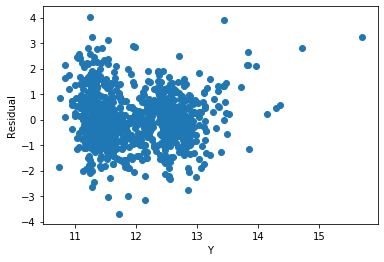

In [156]:
model = lm.fit(X_train1, y_train1)
pred = model.predict(X_train1)
resid = pred-y_train1
sd = np.std(resid)
stand_resid = resid/sd
plt.scatter(pred, stand_resid)
plt.xlabel('Y')
plt.ylabel('Residual')
plt.show()

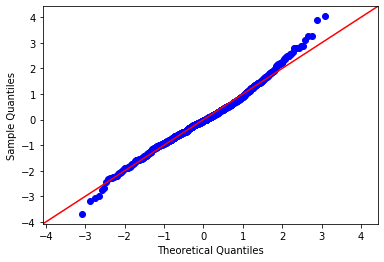

(array([  4.,  10.,  64., 191., 341., 253., 103.,  37.,  12.,   2.]),
 array([-3.68853122, -2.91590208, -2.14327295, -1.37064381, -0.59801467,
         0.17461446,  0.9472436 ,  1.71987274,  2.49250187,  3.26513101,
         4.03776015]),
 <a list of 10 Patch objects>)

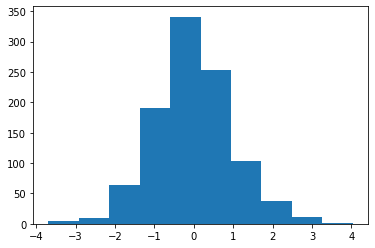

In [157]:
test = np.random.normal(0,1, 1000)

sm.qqplot(stand_resid, line='45')
pylab.show()

plt.hist(stand_resid)

Indeed, normality does improve but we still have the problem with lack of error independence. Below I try multivariate linear regression with log response:

In [167]:
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X_train1, y_train1, scoring=score, cv=10)
print ('Multivariate Regression with Log(Response) MAPE:', round((-scores).mean(),2))

Multivariate Regression with Log(Response) MAPE: 62.71


I will check if there are non linear relationships between response and predictors, to see if transforming predictors improves the model:

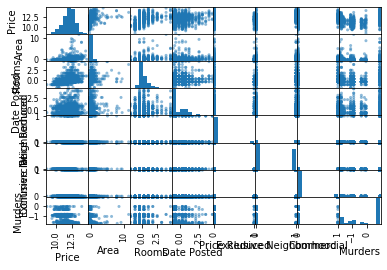

In [106]:
from pandas.plotting import scatter_matrix
scatter_matrix(df1)
plt.show()

The relationship between Price and Area is roughly linear, but could be improved so I will log transform Area. I also apply log transformation to Date Posted to improve linearity with Price. 

In [114]:
dfx = df_original.copy()
dfx['Price']= np.log(dfx['Price'])
dfx['Area']= np.log(df_original['Area'])
dfx['Date Posted']= np.log(df_original['Date Posted'])
scale_df(dfx)

In [115]:
X_trainx, X_testx, y_trainx, y_testx = train_test_split(dfx.loc[:, dfx.columns != 'Price'], dfx['Price'], test_size=0.15, random_state=3)

Indeed, we get the lowest MAE within multivariate linear regression with these transformations:

In [168]:
lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X_trainx, y_trainx, scoring=score, cv=10)
print ('Multivariate Log-Log Regression MAPE:', round((-scores).mean(),2))

Multivariate Log-Log Regression MAPE: 51.55


# PCA Regression

I'll now do PCA regression as a means to eliminate multicollinearity within our predictors. I'll use the data set that yielded the best MAE above. Below, we see that at 4 components we have most of the variance explained, so I will try linear regression with components #4-7 given that we are using PCA merely as a means to reduce multicollinearity. 

Text(0.5, 0, '# Components')

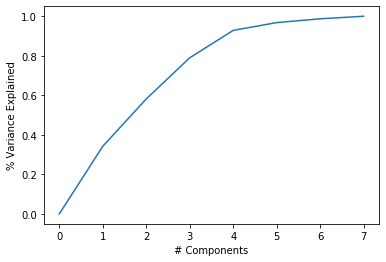

In [126]:
from sklearn.decomposition import PCA

variance = []
for i in range(8):
    pca = PCA(n_components=i)
    principalComponents= pca.fit_transform(X_trainx)
    var= sum(pca.explained_variance_ratio_)
    variance.append(var)

x = range(8)
plt.plot(x, variance)
plt.ylabel('% Variance Explained')
plt.xlabel('# Components')

Below, we see that PCA regression with 5 components yields the best MAPE of %51.48, a slight improvement over our multivariate regression without PCA found above.

In [169]:
for i in range (4,8):
    pca= PCA(n_components=i)
    principalComponents= pca.fit_transform(X_trainx)
    lm = linear_model.LinearRegression()
    scores = cross_val_score(lm, principalComponents, y_trainx, scoring=score, cv=10)
    print ('PCA Multivariate Regression MAE:', round((-scores).mean(),2))

PCA Multivariate Regression MAE: 57.04
PCA Multivariate Regression MAE: 51.48
PCA Multivariate Regression MAE: 51.61
PCA Multivariate Regression MAE: 51.55


## Multivariate Regression Using Elastic Net

I try multivariate regression using Elastic Net (since it provides the benefits of both Ridge and Lasso regression). I used cross validation to find the optimum l1_ratio value, which determines the weights of the ridge vs lasso component. All models improved their accuracy but only slightly. 

In [170]:
from sklearn.linear_model import ElasticNetCV
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
regr = ElasticNetCV(cv=10, l1_ratio = l1_ratio, random_state=0)
scores = cross_val_score(regr, X_train, y_train, scoring=my_scorer, cv=10)
print ('Multivariate Regression with Elastic Net MAPE:', round((-scores).mean(),2))

Multivariate Regression with Elastic Net MAE: 72.77


In [171]:
regr = ElasticNetCV(cv=10, l1_ratio = l1_ratio, random_state=0)
scores = cross_val_score(regr, X_train1, y_train1, scoring=score, cv=10)
print ('Multivariate Regression with Log(Response) and Elastic Net MAPE:', round((-scores).mean(),2))

Multivariate Regression with Log(Response) and Elastic Net MAE: 62.72


In [172]:
regr = ElasticNetCV(cv=10, l1_ratio = l1_ratio, random_state=0)
scores = cross_val_score(regr, X_train2, y_train2, scoring=score, cv=10)
print ('Log-Log Multivariate Regression with Elastic Net MAPE:', round((-scores).mean(),2))

Log-Log Multivariate Regression with Elastic Net MAPE: 51.78


The best multivariate elastic net regression model occures with only taking the loq transform of Area and Date Posted:

In [173]:
regr = ElasticNetCV(cv=10, l1_ratio = l1_ratio, random_state=0)
scores = cross_val_score(regr, X_trainx, y_trainx, scoring=score, cv=10)
print ('Log-Log Multivariate Regression with Elastic Net MAPE:', round((-scores).mean(),2))

Log-Log Multivariate Regression with Elastic Net MAPE: 51.68


## Random Forest Regression

Now I try random forest regression, using randomized search to optimize hyperparameters n_estimators (number of tree in forest), max_features (number of features at every split), and max_depth (maximum tree depth). Note that it is not necessary to use the log or log-log data set, since these transformations only help in linear models:

In [174]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
import random

random.seed(1)
warnings.simplefilter(action='ignore')

rfc = RandomForestRegressor()

# number of trees in random forest, we try 10 values for n_estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

# number of features at every split, try 2 different estimates
max_features = ['auto', 'sqrt']

# max depth, try 10 values for max_depth
max_depth = [int(x) for x in np.linspace(100, 1000, num = 5)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, scoring = my_scorer, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print('Optimum Random Forest Hyperparameters:', rfc_random.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished


Optimum Random Forest Hyperparameters: {'n_estimators': 775, 'max_features': 'sqrt', 'max_depth': 325}


After hyperparameter tuning using RandomizedSearchCV, I run the random forest model using the parameters given by the randomized search:

In [177]:
# Create model with hyperparameters found above
rf = RandomForestRegressor(n_estimators = 775, max_features = 'sqrt', max_depth= 325, random_state = 42)

scores = cross_val_score(rf, X_train, y_train, scoring=my_scorer, cv = 10)

print ('Random Forest MAPE:', round((-scores).mean(),2))

Random Forest MAPE: 54.79


Now I do hyperparameter tuning for the dataframe with log transformation of response variable:

In [178]:
random.seed(1)
rfc = RandomForestRegressor()

# Random search of parameters using same hyperarameters as above
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, scoring = score, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train1, y_train1)

# print results
print('Optimum Random Forest With Log Response Hyperparameters:', rfc_random.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


Optimum Random Forest With Log Response Hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 1000}


In [179]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', max_depth= 1000, random_state = 42)

scores = cross_val_score(rf, X_train1, y_train1, scoring=score, cv = 10)

print ('Random Forest With Log Response MAPE:',round((-scores).mean(),2))

Random Forest With Log Response MAPE: 44.3


There is noticeable improvement with random forest compared to linear regression.

## XG Boost Regression

Note that I did not show hyperparameter optmization because, after trying out different hyperparameters, I found that the XGBRegressor's preset parameters were already the opimum:

In [180]:
from xgboost import XGBRegressor
XGBoost = XGBRegressor(objective ='reg:squarederror')

scores = cross_val_score(XGBoost, X_train, y_train, scoring=my_scorer, cv=10)

print ('XGBoost MAE:', round((-scores).mean(),2))

XGBoost MAE: 53.73


In [181]:
XGBoost = XGBRegressor(objective ='reg:squarederror')

scores = cross_val_score(XGBoost, X_train1, y_train1, scoring=score, cv=10)

print ('XGBoost MAE with log Response:', round((-scores).mean(),2))

XGBoost MAE with log Response: 42.08


In [182]:
XGBoost = XGBRegressor(objective ='reg:squarederror')

scores = cross_val_score(XGBoost, X_train2, y_train2, scoring=score, cv=10)

print ('Log-Log XGBoost MAE:', round((-scores).mean(),2))

Log-Log XGBoost MAE: 42.16


In [183]:
XGBoost = XGBRegressor(objective ='reg:squarederror')

scores = cross_val_score(XGBoost, X_trainx, y_trainx, scoring=score, cv=10)

print ('Log-Log XGBoost MAE:', round((-scores).mean(),2))

Log-Log XGBoost MAE: 42.17


## KNN Regression

In [184]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

knn = neighbors.KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, scoring = my_scorer, cv=10)
#fit model to data
knn_gscv.fit(df.loc[:, df.columns != 'Price'], df['Price'])
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print ('KNN MAE:', round(-knn_gscv.best_score_,2)) 

{'n_neighbors': 4}
KNN MAE: 65.19


In [185]:
knn = neighbors.KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, scoring = score, cv=10)
#fit model to data
knn_gscv.fit(df1.loc[:, df1.columns != 'Price'], df1['Price'])
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print ('KNN MAE with Log (Response):', round(-knn_gscv.best_score_,2))

{'n_neighbors': 18}
KNN MAE with Log (Response): 52.94


In [186]:
knn = neighbors.KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, scoring = score, cv=10)
#fit model to data
knn_gscv.fit(df2.loc[:, df2.columns != 'Price'], df2['Price'])
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print ('Log-Log KNN MAE:', round(-knn_gscv.best_score_,2))

{'n_neighbors': 12}
Log-Log KNN MAE: 46.83


In [187]:
knn = neighbors.KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, scoring = score, cv=10)
#fit model to data
knn_gscv.fit(dfx.loc[:, dfx.columns != 'Price'], dfx['Price'])
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print ('Log-Log KNN MAE:', round(-knn_gscv.best_score_,2))

{'n_neighbors': 12}
Log-Log KNN MAE: 48.39


## Testing Chosen Model

The best performing model in the cross validation step is XGBoost with log response, so I choose it as a final model. The MAPE for this model on the testing set is US56,976, which means that this model's predictions are US56,976 off, on average, of the true listing price. 

In [190]:
XGBoost = XGBRegressor(objective ='reg:squarederror')
XGBoost.fit(X_train1, y_train1)
y_pred = XGBoost.predict(X_test1)
error = np.mean(np.abs((np.exp(y_test1) - np.exp(y_pred)) / np.exp(y_test1))) * 100
print('Log Response XGBoost MAE on testing set:', error)

Log Response XGBoost MAE on testing set: 47.93020999961343


The most important predictor, according to XGBoost model, is Exclusive Neighborhood, meaning that a property's location in or out of an exclusive neighborhood is the most important predictor of the property's listing price. Area follows far behind, and then Rooms and Murders. Price Reduced, Date Posted, and Commercial seem to have almost negligible prediction effect on listing price. 

In [191]:
# Get numerical feature importances of our forest
feature_list = list(X_train1.columns)
importances = list(XGBoost.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Exclusive Neighborhood Importance: 0.6399999856948853
Variable: Area                 Importance: 0.1599999964237213
Variable: Rooms                Importance: 0.07999999821186066
Variable: Murders              Importance: 0.07000000029802322
Variable: Price Reduced        Importance: 0.029999999329447746
Variable: Date Posted          Importance: 0.009999999776482582
Variable: Commercial           Importance: 0.009999999776482582


[None, None, None, None, None, None, None]

## Results and Conclusion

I succesfully built a model- XGBoost using log(response)- that was almost twice more accurate than the baseline model at predicting a property's listing price. Yet, at 47% mean average percentage error, the XGBoost model still has a significant error measure. This may be explained by the fact that the data I used is only on the listed property price, which is different and has more variance compared to the actual property selling price. Listed prices are almost uniformly higher than selling price, but the degree of difference between listed price and true property value (or selling price) may cause a substantial bias in our model (e.g. some people think their property is valued way higher than the market thinks, while others list their homes closer to the actual selling price). My model is not able to account for such listing bias. I surmise that if I could get my hands on a data set of actual selling price, I could create a more robust model. 

The chosen model shows that whether a property is located in an exclusive neighborhood or not is the most important determinant of property price, followed by Area and Murders. Given that almost half of our data set is comprised of properties located in exclusive areas, it is not surprising for the chosen model to assign greater importance to this factor. It also makes sense that, in such a socially divided and crime-ridden nation, a property's exclusivity (and therefore its safety) is the most important determinant of price. Also note that while one would expect a property's degree of neighborhood exclusivity is correlated with crime rates (Murder in our data), our Murder variable only encompasses crime rates among cities, while the 'Exclusive Neighborhood' variable encompasses smaller neighborhods. Thus, these two variables are not particularly correlated which in turn aids our variable interpretation results. 

Surprisingly, whether a property is located in a commerical property was the least important predictor in my model. This came as a surprise, given that my coworkers and I think that the commercial use of a property is one of the most important drivers of price. The low importance of the commerical variable may be explained by the fact that the data I used was scraped from the "homes" listings of Encuentra24, rather than "commercial" listings. Also note that in El Salvador, commercial properties are scattered and priced similarly in both exclusive and non exclusive areas (price is mainly determine by foot traffick), so that it is also not as highly correlated with the exclusive factor. This also allows for more accurate variable interpretation.  

The biggest challenge of this analytics project was finding accurate data. Since my data came from online listings, where anyone can input data about their listing, it is hard to get a 100% clean and accurate data set from this website. A suggestion for the local government would be to gather information about property sales and make this data available to the public, as this would greatly improve analytics models on the subject at hand. 